### Motivación

El objetivo de la geometría visual es la "reconstrucción" de una escena 3D completamente desconocida a partir de varias imágenes.

En los capítulos anteriores hemos trabajado en la situación muy restrictiva de escenas planas que contienen marcadores de referencia artificiales. Con una única imagen somos capaces de rectificar el plano, introducir objetos virtuales y determinar la localización de la cámara.

Esta lección presenta los fundamentos de la geometría de dos vistas (visión estéreo). Una exposición más detallada se puede encontrar en mis [antiguos apuntes](https://robot.inf.um.es/material/va/percep.pdf#chapter.7). 

Hasta ahora sabemos que dos vistas de un plano (o de una escena 3D si la cámara no se desplaza) están relacionadas por una homografía. Pero si escena es 3D y la cámara se desplaza aparece el **paralaje** (los objetos cambian más o menos de posición dependiendo de la profundidad) y ya no se puede transformar una imagen en otra. Aún así, existe una relación entre las dos imágenes (más débil que una sencilla homografía) llamada **"restricción epipolar"** en la que podemos apoyarnos para reconstruir la escena.

El concepto esencial que aprenderemos es:

- Si identificamos varios puntos en dos imágenes de una misma escena podemos determinar (salvo escala) la posición de las cámaras y de los puntos 3D.


### *Depth map*

Antes de empezar es importante recordar que las cámaras RGBD (Red,Green,Blue,Depth) como la [kinect](https://en.wikipedia.org/wiki/Kinect) incluyen un canal de profundidad que permite obtener directamente información 3D sin necesidad de utilizar visión estereoscópica.


<img src="../images/demos/xtion.jpg" width="60%"/>

OpenCV proporciona herramientas para la [manipulación de imágenes RGBD](https://docs.opencv.org/3.4/d2/d3a/group__rgbd.html).

Cuando nos enfrentamos a una nueva aplicación debemos valorar si este tipo de dispositivos es adecuado para las condiciones de trabajo, o si necesitamos recurrir a la geometría de múltiples vistas que estudiaremos a continuación.

# Visión estereoscópica

La figura siguiente resume la situación a la que nos enfrentamos. Tenemos dos vistas de una escena, tomadas por dos cámaras distintas o por una sola cámara que se mueve. Suponemos que la escena observada no cambia.


Cada punto del espacio $P=(X,Y,Z)$ se proyecta en la posición $p_1=(x_1,y_1)$ en la imagen izquierda y en $p_2=(x_2,y_2)$ en la imagen derecha.

<img src="../images/demos/stereo.png" width="50%"/>

Si tenemos las dos matrices de cámara $\mathsf M_1$ y $\mathsf M_2$ es inmediato calcular las imágenes de un punto $P$ conocido:  $p_1 = \mathsf M_1 P$ y $p_2 = \mathsf M_2 P$ (por supuesto, usando coordenadas homogéneas).

Y a la inversa, si lo que conocemos son las proyecciones $p_1$ y $p_2$, asumiendo que corresponden al mismo punto $P$ del espacio, podemos calcular sus coordenadas mediante la intersección de los rayos ópticos. Esta operación se llama **triangulación**.

¿Qué ocurre si desconocemos las matrices de cámara? Una posibilidad es introducir un marcador en la escena para estimarlas como hicimos en el capítulo anterior. Como veremos a continuación, esto no es necesario: las cámaras pueden recuperarse en una escena completamente desconocida si somos capaces de identificar varios puntos coincidentes en ambas imágenes.

Antes de empezar, es interesante echar un vistazo a los conceptos de

- [stellar parallax](https://en.wikipedia.org/wiki/Stellar_parallax): La distancia de objetos en el espacio exterior se mide mediante triangulación.

- [disparity](http://docs.opencv.org/3.1.0/dd/d53/tutorial_py_depthmap.html#gsc.tab=0): La geometría elemental de la triangulación.

- [random dot stereogram](https://en.wikipedia.org/wiki/Random_dot_stereogram), [autostereogram](https://en.wikipedia.org/wiki/Autostereogram): La percepción de profundidad en los humanos es un proceso de bajo nivel que se efectúa antes del reconocimiento de objetos.

- Un artículo sobre la [tecnología de reconstrucción 3D de Google](https://www.trekview.org/blog/2019/google-street-view-cameras-more-than-meets-the-eye/).

### Reproyección de puntos y rectas

El conjunto de puntos del espacio que pueden haber generado un punto de la imagen es una recta (el rayo óptico):

<img src="../images/demos/repropoint.png" width="30%"/>

El conjunto de de puntos del espacio que pueden haber generado una recta de la imagen es un plano:


<img src="../images/demos/reproline.png" width="30%"/>


Si tenemos la matriz de cámara podemos obtener expresiones (sencillas si usamos el formalismo matemático adecuado) para la recta o el plano reproyectados.

### Triangulación

Como hemos comentado más arriba, el punto 3D se consigue mediante la intersección de los rayos ópticos. Ahora bien, dos rectas en el espacio no tienen por qué tocarse. Si las proyecciones $p_1$ y $p_2$ realmente no corresponden al mismo punto obviamente la triangulación fallará. En realidad siempre fallará con datos reales debido al ruido de medida aunque la correspondencia sea correcta. Por esta razón, los algoritmos de triangulación producen soluciones de compromiso como p. ej. el punto más cercano a las dos rectas.

<img src="../images/demos/triangulation2.png" width="50%"/>

(Existen "cámaras estéreo" que tienen las dos cámaras perfectamente alineadas y precalibradas de tal manera que los puntos correspondientes siempre están en la misma fila y el proceso de triangulación se simplifica mucho. Nosotros continuamos analizando el caso general.)

En definitiva, tenemos el

**Resultado 1**: Si conocemos las matrices de cámara podemos triangular puntos correspondientes.

En este momento nos damos cuenta de un **detalle muy importante**:

$$2+2>3$$

¿Qué queremos decir con esto? Que un punto del espacio, que tiene 3 grados de libertad (las coordenadas cartesianas $(X,Y,Z)$) está "codificado" o representado por las dos proyecciones $p_1$ y $p_2$, cada una con 2 grados de libertad, lo que supone un conjunto de 4 números ($x_1, y_1, x_2, y_2$). Por tanto, hay redundancia. Para recuperar el punto 3D en principio bastaría con 3 coordenadas de imagen. (Es la razón de que los rayos en general no se toquen.) Por supuesto, nos viene muy bien tener esta información adicional, gracias a la cual podemos hacer una estimación mejor en presencia de ruido.

Este grado de libertad adicional es más importante de lo que parece: vamos a explotarlo para deducir la posición de las cámaras.

### Geometría epipolar

Imagina que el rayo óptico (en rojo) del punto $x$ (antes lo hemos llamado $p_1$) en la cámara $\mathsf M$ fuera visible en el espacio. Se vería como una recta $l'$ en la otra cámara $\mathsf N$. La imagen $x'$ (antes $p_2$) del punto 3D en esta segunda cámara debe estar necesariamente en esa recta $l'$. Esta recta se llama **recta epipolar**.

<img src="../images/demos/epipolar.png" width="35%"/>

Realmente las dos proyecciones solo tienen 3 grados de libertad: el punto derecho solo puede moverse por la recta epipolar, dependiendo de la distancia a la que se encuentre dentro del rayo óptico del punto izquierdo. Los valores que pueden tomar ($x_1, y_1, x_2, y_2$) están sujetos a la condición $l' \cdot x' = 0$, que se llama "epipolar constraint".


### Restricción epipolar

Si conocemos las matrices de cámara se pueden calcular las recta epipolares de cualquier punto. La forma de hacer esto es muy simple: proyectamos en la segunda imagen dos puntos cualesquiera del rayo óptico y los unimos. Se puede demostrar que esta operación es lineal (con coordenadas homogéneas, por supuesto) y por tanto se reduce a la multiplicación por una matriz $(3\times 3)$. Es la **matriz fundamental** $\mathsf F$ de la pareja de cámaras. Por tanto $l' = \mathsf F x$, donde $\mathsf F$ depende de $\mathsf M_1$ y $\mathsf M_2$.

**Resultado 2**: La relación entre las dos cámaras se condensa en la matriz fundamental $\mathsf F$, que caracteriza la restricción epipolar:

$$x' \cdot \mathsf F x = 0$$




**Resultado 3**: La restricción epipolar sirve para descartar correspondencias erróneas.

Por ejemplo, en la figura siguiente, queremos saber cuál es el punto en la imagen derecha que corresponde con el punto azul que se ve en la imagen izquierda. Hay 4 posibilidades. Los puntos verdes claramente no pueden ser, su color no coincide. De los dos azules podemos descartar el de arriba ya que no cumple la restricción epipolar. 

<img src="../images/demos/epipolar2.png" width="50%"/>



### Reconstrucción estéreo

La matriz $\mathsf F$ que "implementa" la restricción epipolar se puede deducir de un conjunto de puntos correspondientes. La condición $x' \cdot \mathsf F x = 0$ es lineal en los elementos de $\mathsf F$, por lo que podemos encontrar la matriz fundamental resolviendo un sistema de ecuaciones homogéneo (ver [DLT.ipynb](DLT.ipynb)). En la práctica es preferible utilizar la función especializada `cv.findFundamentalMat` que tiene en cuenta que las matrices $\mathsf F$ físicamente posibles tienen rango 2. En definitiva:


**Resultado 4**: Unos pocos puntos correspondientes permiten obtener directamente la geometría epipolar.

---

La segunda idea clave es que es posible encontrar las matrices de cámara $\mathsf M_1$ y $\mathsf M_2$ que han producido una determinada matriz $\mathsf F$.

Veremos cómo hacerlo dentro de un momento pero antes es importante señalar que estas matrices dependen del sistema de referencia del espacio 3D, que para nuestros propósitos ahora es irrelevante. Nos basta con encontrar dos cámaras **compatibles** con la geometría epipolar. Lo importante es la posición relativa entre las cámaras. Por comodidad, una de ellas se pone en el origen de coordenadas. 

Además, es imposible distinguir un objeto real de una maqueta (perfecta) vista desde más cerca. Partiendo de información puramente geométrica solo se puede conseguir una reconstrucción similar de la escena 3D, no euclídea. No se puede deducir la distancia real entre las cámaras ni el tamaño de los objetos.

Pero esa no es la única ambigüedad a la que nos enfrentamos. La imagen $p$ de una escena $P$ tomada con la cámara $\mathsf M$ es idéntica a la de una transformación proyectiva del espacio $P' = \mathsf H P$ observada con una cámara $\mathsf M' =  (\mathsf M \mathsf H^{-1})$. Esta transformación $\mathsf H$ puede incluir deformaciones tremendas, y sin embargo da lugar a la misma matriz fundamental. Por tanto, encontrar cámaras compatibles no es suficiente. Deben ser cámaras que tengan la estructura $\mathsf K [R \mid t]$ de una cámara real, compuesta por una matriz de calibración conocida o razonable y una pose (rotación + desplazamiento). Por tanto, si hacemos que el sistema de referencia del mundo coincida con el de la primera cámara:

$$\begin{aligned}
\mathsf M_1 &= \mathsf K_1 [I \mid 0 ]\\
\mathsf M_2 &= \mathsf K_2 [R \mid t ]
\end{aligned}$$


Supongamos inicialmente que hemos obtenido las matrices $\mathsf K_1$ y $\mathsf K_2$ en un proceso de calibracion previo. Entonces solo queda por determinar la rotación relativa $R$ y (la dirección de) $t$.

Recordemos que la matriz de calibración transforma las coordenadas del plano de imagen, pasando del sistema de referencia "físico" a la malla de pixels. La restricción epipolar expresada mediante la matriz fundamental $\mathsf F$ utiliza coordenadas de pixel $x$, pero puede igualmente expresarse en coordenadas físicas $x_n$ (tambien llamadas normalizadas):

$$x = \mathsf K x_n$$

Por tanto la restricción epipolar $ x' \cdot \mathsf F x = 0$ es equivalente a $x_n' \cdot \mathsf E \,x_n = 0$, donde la matriz $\mathsf E$ se llama **matriz esencial** del par estéreo. Está directamente relacionada con $\mathsf F$:

$$ x_n\cdot \, \underbrace{\mathsf K^\mathsf T\, \mathsf F\, \mathsf K}_{\mathsf E} \, x_n = 0 $$

La matriz esencial tiene una estructura matemática muy simple: $\mathsf E = t_\times R $ (donde $t_\times$ es una matriz que implementa el producto vectorial por $t$), por lo que llegamos al

**Resultado 5**:  De la geometría epipolar se pueden extraer las cámaras (precalibradas).


### Teorema fundamental de la geometría visual

Resumiendo lo anterior:

- puntos correspondientes $\rightarrow$ matriz $\mathsf F$

- matriz $\mathsf F$ $\rightarrow$ cámaras

- puntos correspondientes $+$ cámaras $\rightarrow$  puntos 3D

En conclusión: **puntos correspondientes  $\rightarrow$  puntos 3D**.

Teniendo en cuenta lo siguiente:

- La escala real de la reconstrucción se desconoce (hay que identificar algo de tamaño conocido en la escena).

- Necesitamos las matrices de calibración $\mathsf K$.

- Si solo desconocemos el parámetro $f$ hay métodos de **autocalibración** que pueden deducirlo de la matriz $\mathsf F$.

---

Este video musical explica perfectamente este capítulo: [The Fundamental Matrix Song](http://danielwedge.com/fmatrix).

Aquí está la explicación de la [geometría epipolar en OpenCV](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html).

(Pendiente: demo interactiva, disponible en docker.)

Dentro de un momento veremos un ejemplo numérico de estas ideas con la ayuda de OpenCV. Antes comentaremos brevemente lo que ocurre cuando tenemos más de dos imágenes.

### Geometría de 3 vistas

En la imagen central de la figura siguiente se muestran las rectas epipolares generadas por la proyección $p_1$ en la cámara izquierda, y $p_2$ en la derecha, ambos correspondientes a un mismo punto del espacio. Su intersección nos dice donde debe estar la proyección $p_3$ en la imagen central.

<img src="../images/demos/transfer.png" width="55%"/>

Esta operación se llama "epipolar transfer". Es equivalente a triangular el punto $P$ con las imágenes de ambos lados y después proyectarlo en la imagen central. Hacerlo con epipolar transfer tiene interés porque demuestra que se puede predecir "directamente", sin pasar por el espacio 3D, la posición en una tercera imagen de un punto si lo vemos en otras dos imágenes. Esto en la práctica no es muy útil. Sin ir más lejos, el cálculo de la intersección está mál condicionado si las rectas epipolares son casi paraleas. Sin embargo esto indica que existe algún tipo de restricción en la geometría de tres vistas.

Efectivamente, esta restricción existe y es mejor que 3 pares de restricciones epipolares. Se llama **restricción trifocal** y la mejor forma de expresarla es con rectas. En la figura siguiente se ven las proyecciones en tres cámaras de una recta en el espacio. Los planos retroproyectados de dos cualquiera de ellas se intersectarán en una recta 3D. La recta proyectada en la tercera imagen queda fijada completamente.

<img src="../images/demos/trifocal.png" width="55%"/>

La operación lineal que obtiene la línea $l_3$ a partir de $l_1$ y $l_2$ se llama **tensor trifocal** $\mathcal T$.

$$l_3 = \mathcal T (l_1, l_2)$$

(Un tensor es una transformación multilineal, es decir una función de varias variables vectoriales, que se comporta linealmente (como un producto matriz-vector), en cada uno de los argumentos. Se representa mediante un array multidimensional de coeficientes.)

El tensor trifocal se puede deducir de un conjunto de tripletas de líneas (o puntos) correspondientes y de él se puede extraer la posición relativa de las cámaras.

### Geometría de múltiples vistas

Se han estudiado también las configuraciones de 4 y más vistas, hasta llegar al caso general de la reconstrucción 3D a partir de múltiples vistas ([Structure From Motion](https://en.wikipedia.org/wiki/Structure_from_Motion)).

<img src="../images/demos/sfm.png" width="50%"/>

Es un problema que se considera resuelto tras una época de importantes avances teóricos.

El software [VisualSFM](http://ccwu.me/vsfm/) fue un avance muy relevante en su momento.

Hay productos comerciales como [Pix4d](https://www.sensefly.com/drones/photogrammetry-software.html) que obtiene modelos 2D y 3D a partir de imágenes de drones.

## Experimentos

Preparamos algunas utilidades.

In [1]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import numpy.linalg      as la
import matplotlib.pyplot as plt

from ipywidgets          import interactive

from umucv.htrans import homog, inhomog, jc, col
from umucv.util   import shline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def readgray(file):
    return cv.imread('../images/'+file, 0) 

def imshowg(x):
    plt.imshow(x, 'gray')
    
# matriz de calibración sencilla dada la
# resolución de la imagen y el fov horizontal en grados
def Kfov(sz,hfovd):
    hfov = np.radians(hfovd)
    f = 1/np.tan(hfov/2)
    # print(f)
    w,h = sz
    w2 = w / 2
    h2 = h / 2
    return np.array([[f*w2, 0,    w2],
                     [0,    f*w2, h2],
                     [0,    0,    1 ]])

## Mapa de profundidad denso

El caso más simple posible de la visión estéreo ocurre cuando partimos de un **par estéreo rectificado**: los puntos correspondientes están en la misma fila de pixels. (Obtenido por software, o con una cámara estéreo precalibrada).

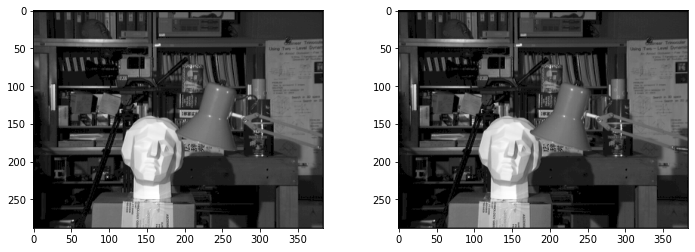

In [2]:
# ejemplo típico que aparece en muchos libros
x1 = readgray('tsukuba-l.png')
x2 = readgray('tsukuba-r.png')

fig(12,4)
plt.subplot(1,2,1); imshowg(x1)
plt.subplot(1,2,2); imshowg(x2)

Superponiendo las dos se aprecia la disparidad.

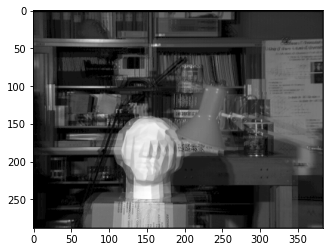

In [3]:
imshowg(x1//2 + x2//2)

Usaremos un *stereo matcher* de opencv para determinar la disparidad de cada pixel.

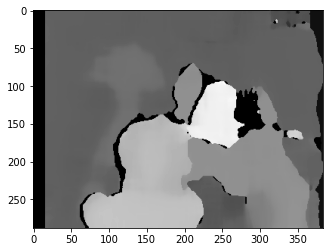

In [4]:
sgbm = cv.StereoSGBM_create(0,16,30)
disparity = sgbm.compute(x1,x2)
imshowg(disparity)

Si conocemos la separación entre las cámaras podemos convertir estas disparidades en un mapa de profundidad.

## Estudio de la geometría epipolar 

Un problema más interesante es la reconstrucción 3D cuando desconocemos la posición de las cámaras. En un primer ejercicio vamos a utilizar correspondencias marcadas a mano para verificar los algoritmos.

Hemos elegido puntos 3D con una estructura muy regular para comprobar visualmente la corrección de los algoritmos. En la práctica los puntos correspondientes suelen estar dispersos de cualquier manera en el espacio.

Cuando la **línea base** (la distancia entre las cámaras) es pequeña se pueden usar detectores de keypoints para encontrar correspondencias automáticamente, como veremos en el ejercicio siguiente. Este experimento es de línea base ancha, donde sería necesario usar "tracking" de Lucas-Kanade si quisiera hacerse de forma automática. 

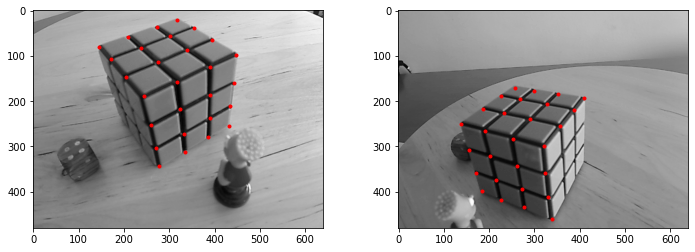

In [5]:
v1 = np.array(
      [[ 278.,  343.],
       [ 335.,  312.],
       [ 386.,  279.],
       [ 433.,  254.],
       [ 270.,  304.],
       [ 332.,  272.],
       [ 389.,  238.],
       [ 434.,  210.],
       [ 260.,  253.],
       [ 324.,  218.],
       [ 389.,  186.],
       [ 442.,  160.],
       [ 244.,  189.],
       [ 317.,  158.],
       [ 390.,  125.],
       [ 447.,   97.],
       [ 204.,  147.],
       [ 276.,  114.],
       [ 340.,   87.],
       [ 395.,   64.],
       [ 172.,  107.],
       [ 238.,   83.],
       [ 302.,   55.],
       [ 355.,   39.],
       [ 146.,   81.],
       [ 210.,   58.],
       [ 273.,   37.],
       [ 318.,   21.]])

v2 = np.array(
      [[ 184.,  399.],
       [ 226.,  418.],
       [ 277.,  434.],
       [ 338.,  460.],
       [ 171.,  358.],
       [ 216.,  374.],
       [ 273.,  394.],
       [ 331.,  412.],
       [ 155.,  307.],
       [ 203.,  321.],
       [ 262.,  342.],
       [ 324.,  358.],
       [ 138.,  251.],
       [ 191.,  265.],
       [ 252.,  284.],
       [ 321.,  299.],
       [ 186.,  218.],
       [ 233.,  227.],
       [ 291.,  240.],
       [ 357.,  255.],
       [ 226.,  188.],
       [ 269.,  196.],
       [ 327.,  206.],
       [ 387.,  220.],
       [ 257.,  170.],
       [ 299.,  177.],
       [ 352.,  185.],
       [ 409.,  194.]])

rgb1 = readrgb('cube3.png')
rgb2 = readrgb('cube4.png')

x1 = rgb2gray(rgb1)
x2 = rgb2gray(rgb2)

fig(12,4)
plt.subplot(1,2,1)
imshowg(x1); ax = plt.axis()
plt.plot(v1[:,0],v1[:,1],'.r'); plt.axis(ax)
plt.subplot(1,2,2)
imshowg(x2)
plt.plot(*v2.T,'.',color='red'); plt.axis(ax);

Cuando no hay outliers (correspondencias erróneas) la matriz $\mathsf F$ se puede obtener resolviendo un sencillo sistema de ecuaciones. En la práctica es mejor usar la función  `cv.findFundamentalMat` de OpenCV, que utiliza algoritmos de estimación robustos. La opción `cv.FM_LMEDS` es una alternativa a RANSAC que consigue un resultado parecido en presencia de outliers.

In [6]:
F,_ = cv.findFundamentalMat(v1, v2, cv.FM_LMEDS)
F

array([[ 1.19789663e-06,  6.12855256e-06,  8.51137650e-04],
       [ 1.04276245e-05,  2.57755811e-06, -1.37042447e-02],
       [ 1.02107838e-03,  5.88401371e-03,  1.00000000e+00]])

Comprobemos que la restriccion epipolar $x' \cdot \mathsf F x = 0$ se cumple:

In [7]:
[ x2 @ F @ x1 for x1,x2 in zip(homog(v1),homog(v2)) ]

[-0.05183794546237852,
 -0.038979293439957985,
 -0.015402972982851537,
 8.881784197001252e-16,
 -0.03379516631784796,
 0.0008633756549425442,
 -0.004204385192221771,
 0.0,
 8.881784197001252e-16,
 0.0021508341492753047,
 -0.0002497815328776909,
 0.04932851340356503,
 8.881784197001252e-16,
 0.025669930331960966,
 0.013449176188173428,
 0.0339649490290066,
 0.0033938903880534887,
 -0.00011874031483793956,
 -0.0038717892426776146,
 -0.009488620565590189,
 0.004977182311009631,
 0.01619734152324881,
 -0.0063197525904075125,
 2.220446049250313e-16,
 -0.01846449040266962,
 -0.0199085898600162,
 4.440892098500626e-16,
 4.440892098500626e-16]

Debido al ruido de medida no son ceros perfectos pero el residuo numérico es razonablemente pequeño.

La matriz fundamental nos da las rectas epipolares de cualquier punto (la recta donde debe estar ese punto en la otra imagen).

In [8]:
# elegimos un punto cualquiera
n = 10
pt1 = homog(v1[n])
pt1

array([389., 186.,   1.])

In [9]:
# calculamos su línea epipolar
lepi = F @ pt1

lepi

array([ 2.45703022e-03, -9.16847292e-03,  2.49162604e+00])

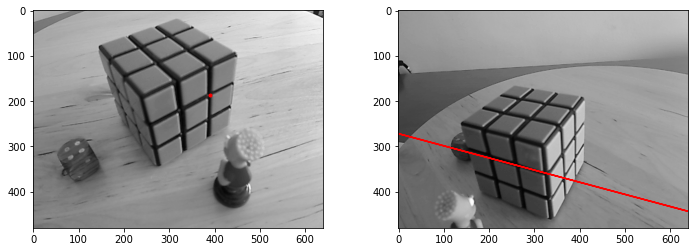

In [10]:
fig(12,4)
plt.subplot(1,2,1)
imshowg(x1); ax = plt.axis()
plt.plot(*v1[n],'.',color='red'); plt.axis(ax)
plt.subplot(1,2,2)
imshowg(x2)
shline(lepi)
plt.axis(ax);

$\mathsf F^T$ hace el mismo trabajo con la imagen derecha.

In [11]:
pt2 = (160,410,1)  # p.ej., la nariz de Bart

In [12]:
lepi = F.T @ pt2

lepi

array([ 0.00548807,  0.00792138, -4.48255829])

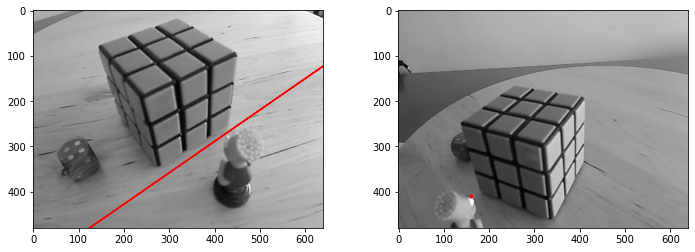

In [13]:
fig(12,4)
plt.subplot(1,2,1)
imshowg(x1);
ax = plt.axis()
shline(lepi)
plt.axis(ax)
plt.subplot(1,2,2)
imshowg(x2)
plt.plot(pt2[0],pt2[1],'.',color='red'); plt.axis(ax);

Para extraer las cámaras necesitamos la matriz de calibración. (Luego veremos que en ciertos casos se puede *autocalibrar*.)

In [14]:
# Esta es una buena aproximación
K = Kfov((640,480), 64)
K

array([[512.10704929,   0.        , 320.        ],
       [  0.        , 512.10704929, 240.        ],
       [  0.        ,   0.        ,   1.        ]])

El primer paso es formar la matriz Esencial, que "implementa" la restricción epipolar con coordenadas normalizadas (en el sistema de referencia físico, no de pixels).

In [15]:
E = K.T @ F @ K

print(E)

[[ 0.31415274  1.60723516  1.385412  ]
 [ 2.73468238  0.67597397 -4.99242453]
 [ 2.00082026  4.33435345  1.26490006]]


La matriz esencial codifica internamente la rotación relativa entre las cámaras y la dirección del desplazamiento entre ellas. Por su estructura matemática debe tener dos [valores singulares](https://en.wikipedia.org/wiki/Singular_value_decomposition) iguales y el tercero nulo.

Veamos si nuestra matriz esencial lo cumple:

In [16]:
print(la.svd(E)[1])

[5.80910705e+00 5.30142843e+00 4.86526533e-16]


No es una matriz esencial perfecta, pero tiene una calidad muy aceptable.

Finalmente, de la matriz Esencial extraemos un par de cámaras consistentes con las imágenes observadas. Pero hay 4 soluciones posibles, de las cuales solo una es físicamente aceptable.

La función de OpenCV que implementa este algoritmo es `cv.decomposeEssentialMat`, que devuelve la 4 posibilidades de forma compacta. La forma de desempaquetar las cámaras es la siguiente:

In [17]:
RE1,RE2,t = cv.decomposeEssentialMat(E)

# cámara en el origen, es común en las 4 posibilidaes
M0 = K @ jc(np.eye(3),col(0,0,0))   

# 4 posibilidades para la otra cámara
# (jc hace una matriz por bloques juntando columnas)
M1_1 = K @ jc(RE1,t)
M1_2 = K @ jc(RE2,t)
M1_3 = K @ jc(RE1,-t)
M1_4 = K @ jc(RE2,-t)

# Mostramos la primera posibilidad
print(M0)

print(M1_1)

[[512.10704929   0.         320.           0.        ]
 [  0.         512.10704929 240.           0.        ]
 [  0.           0.           1.           0.        ]]
[[ 2.74859794e+01 -2.75115983e+02  5.36851327e+02  3.52614369e+02]
 [ 8.31762222e+01  4.29219221e+02  3.58756472e+02 -4.74785456e+00]
 [-7.11346735e-01  1.17862790e-01  6.92888292e-01 -3.65189126e-01]]


Probando las 4 posibilidades vemos que en este caso el par M0-M1_4 es el único que triangula todos los puntos delante de las dos cámaras. (Este paso se puede automatizar.)

In [18]:
# preparamos un gráfico 3D
from mpl_toolkits.mplot3d import Axes3D
from umucv.util import cameraOutline

def plot3(ax,c,color):
    ax.plot(c[:,0],c[:,1],c[:,2],color)

La función de OpenCV que implementa el proceso de triangulación es `cv.triangulatePoints`. Observa que recibe coordenadas cartesianas pero devuelve coordenadas homogéneas (lo que permite recontruir puntos en el infinito). Además los arrays se organizan por columnas.

Probamos la primera solución:

In [19]:
p3d = cv.triangulatePoints(M0, M1_1, v1.T, v2.T)
p3d = inhomog(p3d.T)

In [20]:
def fun(a=90):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    plot3(ax,cameraOutline(M0),'blue');
    plot3(ax,cameraOutline(M1_4),'red');
    plot3(ax,p3d,'.g')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=90, description='a', max=180, min=-180, step=10), Output()), _dom_classe…

Esta solución no es válida porque algunos puntos quedan por detrás las cámaras. Probando las demás vemos que la correcta en este caso el la cuarta:

In [21]:
p3d = cv.triangulatePoints(M0, M1_4, v1.T, v2.T)
p3d = inhomog(p3d.T)

In [22]:
def fun(a=90):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    plot3(ax,cameraOutline(M0),'blue');
    plot3(ax,cameraOutline(M1_4),'red');
    plot3(ax,p3d,'.g')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=90, description='a', max=180, min=-180, step=10), Output()), _dom_classe…

Cambiando del punto de vista se observa que los puntos 3D reconstruidos están claramente en dos planos perpendiculares de acuerdo con la estructura del cubo de Rubik.

En una aplicación real el paso siguiente es una **rectificación estéreo**. Se aplica una homografía a las imágenes para que queden igual que si se hubieran tomado con un par estéreo alineado, lo que permite obtener un mapa de profundidad con el stereo matcher utilizado en el experimento inicial.

### Autocalibración

Si desconocemos la matriz de calibración $\mathsf K$ podemos buscar una aproximación que dé lugar a una matriz esencial $\mathsf E$ geométricamente válida. (Suponemos la misma $\mathsf K$ en las dos vistas.)

Si como es usual la cámara tiene pixel cuadrado, solo merece la pena explorar el parámetro $f$ de la cámara (a través del FOV).

In [23]:
# si el fov es correcto los dos valores singulares de E = KT F K serán iguales
def quality(F, fov):
    K = Kfov((640,480),fov)
    E = K.T @ F @ K
    s1,s2,_ = la.svd(E)[1]
    return (s1-s2)/s1

In [24]:
quality(F, 80), quality(F, 50)

(0.1276718678240634, 0.17945150269344118)

Probamos todos los valores del campo visual en un rango amplio (p. ej. entre 20 y 130 grados) para ver cuál recupera mejor la matriz esencial:

68.5


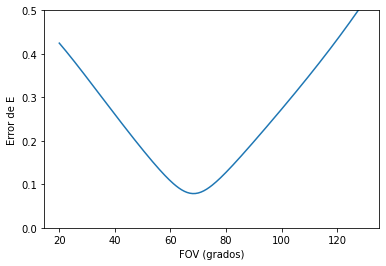

In [25]:
fovs = np.arange(20,130,0.5)
Qs = [quality(F, f) for f in fovs]
plt.plot(fovs,Qs);
plt.xlabel('FOV (grados)');
plt.ylabel('Error de E');
plt.ylim(0,0.5);

print(fovs[np.argmin(Qs)])

Si la rotación relativa entre las imágenes es pequeña este método será muy impreciso.

La posibilidad de autocalibración es un resultado teórico muy importante. En principio se puede resolver el ejercicio FOV simplemente moviendo la cámara, sin necesidad de insertar en la escena ningún objeto de referencia. Pero en la práctica la autocalibración es muy sensible al ruido de medida. Es recomendable trabajar con cámaras precalibradas siempre que sea posible.

## Segundo ejemplo

Con "línea base" pequeña podemos obtener F automáticamente con puntos de interés.

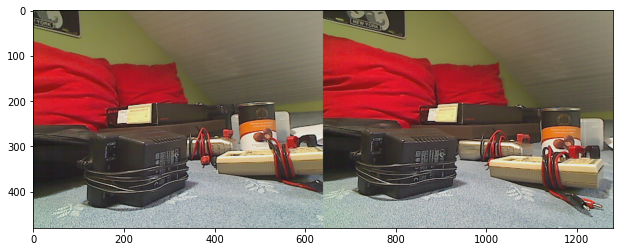

In [26]:
rgb1 = readrgb('left.png')
rgb2 = readrgb('right.png')

x1 = rgb2gray(rgb1)
x2 = rgb2gray(rgb2)

fig(12,4)
imshowg(np.hstack([rgb1,rgb2]));

In [27]:
sift = cv.SIFT_create()
(k1, d1) = sift.detectAndCompute(x1, None)
(k2, d2) = sift.detectAndCompute(x2, None)
print(len(k1),len(k2))

1133 1238


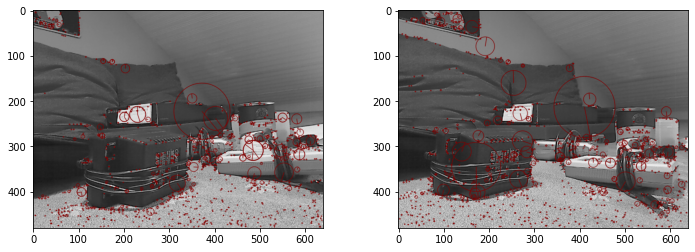

In [28]:
fig(12,4)
plt.subplot(1,2,1)
plt.imshow( cv.drawKeypoints(image=x1,
                             outImage=None,
                             keypoints=k1,
                             flags=4, color = (128,0,0)) );
plt.subplot(1,2,2)
plt.imshow( cv.drawKeypoints(image=x2,
                             outImage=None,
                             keypoints=k2,
                             flags=4, color = (128,0,0)) );

In [29]:
bf = cv.BFMatcher()

matches = bf.knnMatch(d2,d1,k=2)

len(matches)

# Apply ratio test
good = []
for mt in matches:
    if len(mt) == 2:
        best, second = mt
        if best.distance < 0.75*second.distance:
            good.append(best) 

print(len(good))

143


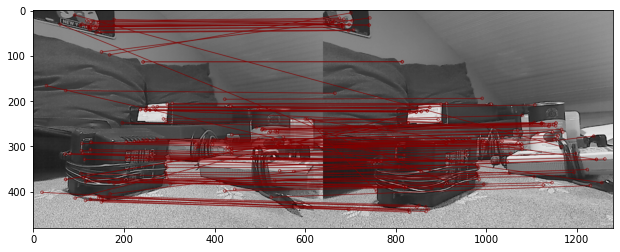

In [30]:
img3 = cv.drawMatches(x2,k2,
                      x1,k1,
                      good,
                      flags=2,outImg=None,
                      matchColor=(128,0,0))
fig(12,4)
plt.imshow(img3);

Como siempre ocurre en estos casos algunas correspondencias son erróneas pero se eliminarán al no cumplir la restricción epipolar.

In [31]:
# ponemos los puntos en el formato admitido por cv.findFundamentalMat
p1r = np.array([ k1[m.trainIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)
p2r = np.array([ k2[m.queryIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)

# usamos método robusto frente a correspondencias erróneas ("outliers")
F, mask = cv.findFundamentalMat(p1r,p2r,cv.FM_LMEDS)

F

array([[ 1.12710483e-06,  1.56496167e-05, -4.59465619e-03],
       [ 6.09728634e-06, -2.82296102e-06, -7.29585080e-02],
       [ 2.96295511e-03,  6.49253443e-02,  1.00000000e+00]])

Seleccionamos las correspondencias "buenas".

In [32]:
mask = mask.ravel() > 0  # viene en formato raro, lo pasamos a array de bool

# inliers
p1 = p1r[mask]
p2 = p2r[mask]

ok = [ x for x,ok in zip(good,mask) if ok]

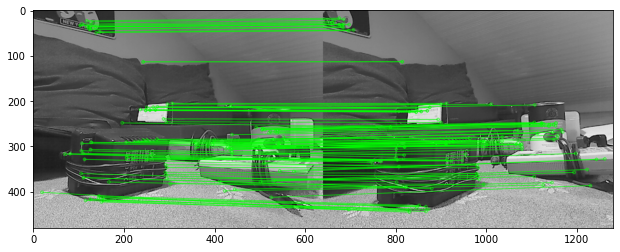

In [33]:
fig(12,4)
img4 = cv.drawMatches(x2,k2,x1,k1,ok,flags=2,outImg=None,matchColor=(0,255,0))
plt.imshow(img4);

Ahora podríamos continuar como en el ejercicio anterior: obtener matriz esencial, cámaras candidatas y triangulación.

Pero en este caso vamos a intentar obtener un mapa de disparidad denso, rectificando antes las imágenes para que los puntos correspondientes estén en la misma fila de pixels y cercanos entre sí. Hay un método calibrado y otro no calibrado. Probaremos este último.

In [34]:
_,H1,H2 = cv.stereoRectifyUncalibrated(p1,p2,F,(640,480))

In [35]:
x1r = cv.warpPerspective(rgb1,H1,(640,480))
x2r = cv.warpPerspective(rgb2,H2,(640,480))

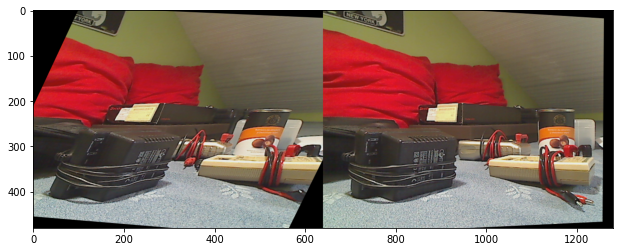

In [36]:
fig(12,4)
imshowg(np.hstack([x1r,x2r]))

Las superponemos para comprobar visualmente que los puntos correspondientes están a la misma altura:

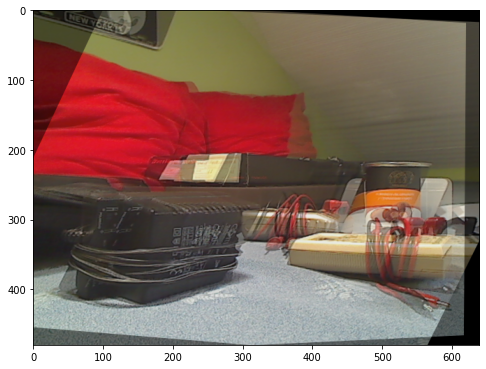

In [37]:
fig(8,8)
xm=(x1r//2+x2r//2)
imshowg(xm)

El resultado parece correcto: en todos los casos los puntos correspondientes están en la misma fila y relativamente cerca, lo que facilita el cálculo de disparidad densa.

Continuará...

## Resumen de la teoría

Deseamos obtener la estructura 3D de una escena a partir de dos imágenes.

Es necesario que los centros de proyección estén separados en el espacio. Si no es así las imágenes se relacionan por una homografía (son esencialmente equivalentes), no hay disparidad.

Si conocemos las matrices de cámara podemos hacer triangulación de puntos correspondientes para deducir su posición en el espacio.

La triangulación es muy simple si las cámaras están alineadas. En este caso se puede intentar obtener un mapa de profundidad denso.

Si la escena contiene un objeto de referencia podemos estimar fácilmente las matrices de cámara.

Pero en muchos casos desconocemos todo: las matrices de cámara y la escena. (Cuando sea posible es muy conveniente tener cámaras precalibradas.)

El resultado fundamental de la geometría de dos vistas es que los puntos correspondientes tienen que estar en las líneas epipolares.

Esta "restricción epipolar" es la consecuencia de que los rayos ópticos de puntos correspondientes y la línea base forman un triángulo en el espacio.

Esa condición nos permite descartar correspondencias erróneas.

Gracias a que trabajamos con coordenadas homogéneas, las líneas epipolares se consiguen mediante una transformación lineal cuya matriz de coeficientes es la **matriz fundamental** $\mathsf F$ del par estéreo. $\mathsf F$ se puede construir fácilmente a partir de las cámaras.

Los puntos correspondientes cumplen $x' \cdot \mathsf F x = 0$.

A partir de puntos correspondientes podemos encontrar $\mathsf F$.

A partir de $\mathsf F$ podemos encontrar cámaras compatibles, que nos permiten triangular los puntos correspondientes.

Si desconocemos las matrices de calibración $\mathsf K$ la reconstrucción tiene ambigüedad proyectiva. Existen deformaciones del espacio que, con cámaras deformadas "inversamente", producen la misma geometría epipolar $\mathsf F$.

Esta solución tiene en general poca utilidad. Normalmente nos interesa una solución que solo tenga ambiguedad de escala.

Si conocemos las $\mathsf K$ la restricción epipolar sobre pixels crudos puede expresarse sobre coordenadas normalizadas (imagen óptica ideal) por medio de la **matriz esencial** $\mathsf E$ del par estéreo. Los puntos normalizados cumplen $x_n' \cdot \mathsf E x_n = 0$.

La matriz esencial depende solo de la dirección del desplazamiento $t$ y de la orientación relativa $R$ entre las dos cámaras.

$R$ y $t$ se pueden extraer fácilmente de la matriz esencial estimada, lo que permite encontrar "cámaras reales", con la única ambigüedad de la longitud de la línea base. Por tanto la reconstrucción solo tendrá ambigüedad de escala.

Hay 4 soluciones posibles, de las cuales solo una tiene sentido físico (la que reconstruye (triangula) los puntos por delante).

En conclusión, $\mathsf K$ + puntos correspondientes $\rightarrow$ posición de las cámaras  + estructura 3D de la escena. Es lo que se conoce como el problema *SfM* (structure from motion) o *SLAM* simultaneous localization and mapping.

Si desconocemos $\mathsf K$ no todo está perdido: existen métodos de autocalibración.